<a href="https://colab.research.google.com/github/codeMaverick7770/twitter-data-sentiment-analysis/blob/main/Twitter_Data_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T061247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c1ab22517ad4546734cd7b99a495cb3ca5dc027ede273f914405b2037a309e1191add26563e388593545c2a11becbf31f3d74ad139018c317ffe8b1e0e17f32d8d88d0ca2d642850d5c5d29eec01a9155a9e436c06eed4c4da4ea77393e4f2e42ef6b875e0e4e1a0f942dd87f28880625d72bc0f63de29caee5f313a1b239005821c2c002eef8e36d101713c3b55ce592ad127fdce51cdeb48fd52ff81fa5c3bddb85d756e33529377a038a239dccacc2b09e9c303d86b00ac604cdf1227a3aa364b86710802655fb5960b55f70821e6e806616a1b9255b4e085ba95f49c71fb3b7fdb4d7dc0cfc719aeec95a7e3149181d1e060ceb3a6724254d8048ccc34b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
Data source import complete.


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Natural Language Processing</span>
</div>


**Natural Language Processing (NLP)** is a field within Artificial Intelligence that focuses on enabling machines to comprehend human languages. These natural languages can be expressed in text or sound, which humans use for communication. NLP allows humans to interact with machines in a natural and intuitive manner.

**Text Classification** plays a vital role in Sentiment Analysis. It involves categorizing people's opinions or expressions into various sentiments, such as *Positive, Neutral*, and *Negative*, as well as *Review Ratings* and emotional states like *Happy* or *Sad*. Sentiment Analysis is widely used in consumer-focused industries to gauge public opinion about a specific product or topic.
![Sentiment Analysis]

> Sentiment Classification is an excellent introductory problem in NLP. It provides a hands-on way to learn a variety of concepts and techniques essential for mastering the field.

In this notebook, I will cover the key concepts of NLP and Sequence Models.
![Sentiment Analysis]

Let's dive into the code without further delay.

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Importing Libraries</span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    Let's begin by importing all the necessary libraries. The specific use of each library will be explained later in this notebook.
</p>


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.15.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.15.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Dataset Preprocessing</span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    In this notebook, we're utilizing the <strong>Training.csv</strong> dataset for my major assignment project from <strong>InternzLearn</strong>. This dataset includes 1.6 million labeled tweets, offering a substantial amount of data to effectively train our model.
</p>


In [4]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.sample(6).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,0,1,2,3,4,5
880102,4,1685573416,Sun May 03 01:00:47 PDT 2009,NO_QUERY,katiexoxox,@taylorswift13 i love you belong with me sooo good. well done
784485,0,2324180274,Thu Jun 25 02:29:55 PDT 2009,NO_QUERY,cromwellswirral,"3 hours sleep, feeling really emotional, having a sad day."
647928,0,2236891752,Fri Jun 19 04:45:45 PDT 2009,NO_QUERY,wilsonleah,Trying to get ready for work...just can't get motivated.
661622,0,2243248799,Fri Jun 19 13:12:35 PDT 2009,NO_QUERY,primadita,"bye bye Rafael Nadal, guess we won't see U at Wimbledon this year get well soon with d knee injury"
953348,4,1824636977,Sun May 17 02:15:19 PDT 2009,NO_QUERY,Tanja71,@its_me_Miss_B Moin Missy
447156,0,2068623654,Sun Jun 07 14:24:20 PDT 2009,NO_QUERY,kateweb,@misswiz http://twitpic.com/6up0q - Sorry Sarah - I gave you red eye I did think it was just going to be full of manic hair....


You can see the columns are without any proper names. Lets rename them for our reference

In [5]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Since we're focusing on classifying sentiment based solely on text, we can discard the irrelevant columns and keep only the text data for training. This will streamline our process and ensure that our model is only learning from the pertinent information.

In [6]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [7]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


We’ve decoded the labels, mapping **0 to Negative** and **1 to Positive** as specified in the dataset description. Next, we'll analyze the dataset to understand the distribution of these classes. It’s crucial to ensure that we have a balanced number of examples for each class to avoid any potential biases.

Text(0.5, 1.0, 'Sentiment Data Distribution')

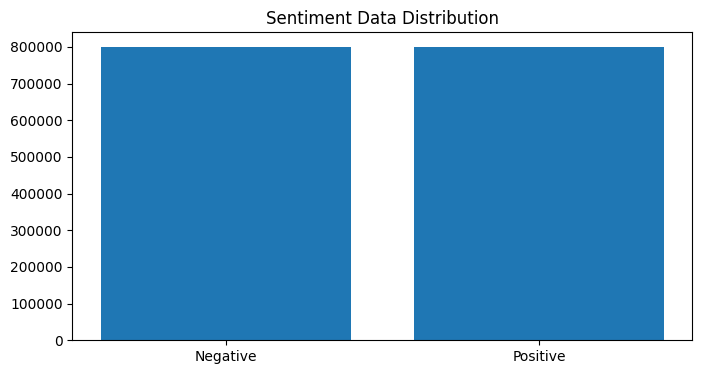

In [8]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It’s great to see that the dataset is well-balanced and free from any skewness. Now, let’s delve into the data and explore its details.

In [9]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
585998,Negative,I really hope its not real.
122484,Negative,wow...another Monday more...but this is the last but one to finish the hell...I'm afraid the marks... I'm not sure about anything
1099036,Positive,#myweakness Is music and i live to meet the people who make it
221710,Negative,Tweet deck doesnt seem to be working
896739,Positive,"Dude, shit just got creepy. It's a bit Wonderland-y. Reminds me of Code Geass. Super cute, but it seems to have a big plot. Cool."
1037880,Positive,My life is amazing big interview tomorow!
781693,Negative,@LindsNBoots you are probably getting up to go running soon and I can't even fall asleep
1239716,Positive,"AND I'm still trying to get through the after-gig-depression. mcfly, why do you do this to me? haha!"
575857,Negative,Soup dammit! Not even a pack of ramen noodles in this house...
1242012,Positive,@LiaWhiting Boa tarde


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;"> Preprocessing the Text</span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    It appears that our text data contains a lot of noise, such as punctuations and meaningless words. These elements do not add value as features for the model we are training, so we need to remove them.
</p>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    Tweet texts often consist of user mentions, hyperlinks, emoticons, and punctuations. To use these texts for learning with a Language Model, we need to clean the data. This involves various preprocessing and cleansing methods. Let's continue.
</p>




### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word


### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...
![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

That looks like a tedious process, isn't?. Don't worry there is always some library in Python to do almost any work. The world is great!!!

**NLTK** is a python library which got functions to perform text processing task for NLP.



In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

**It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

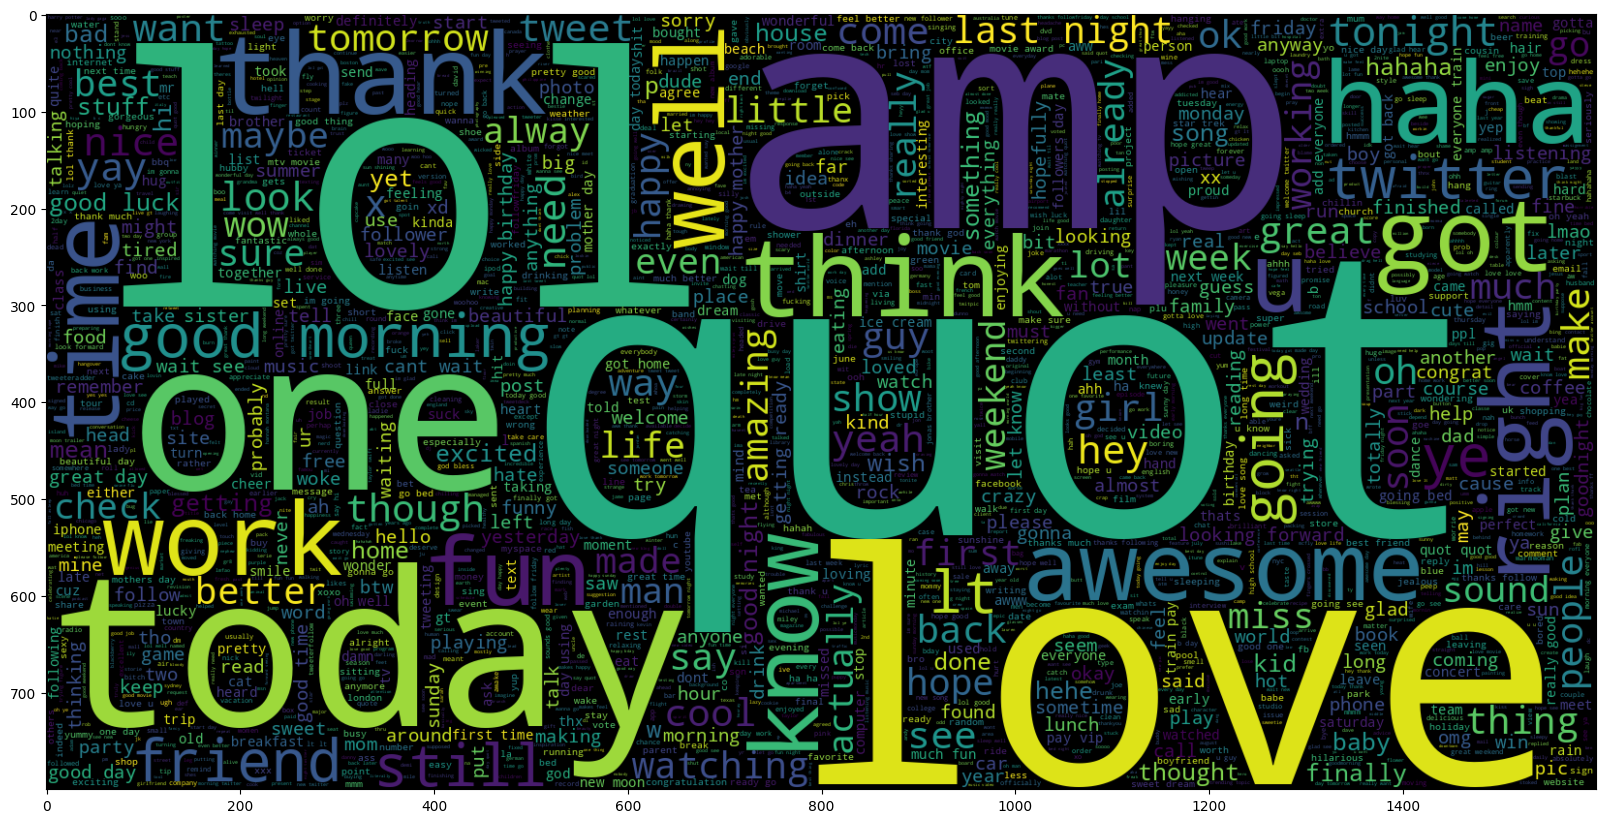

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

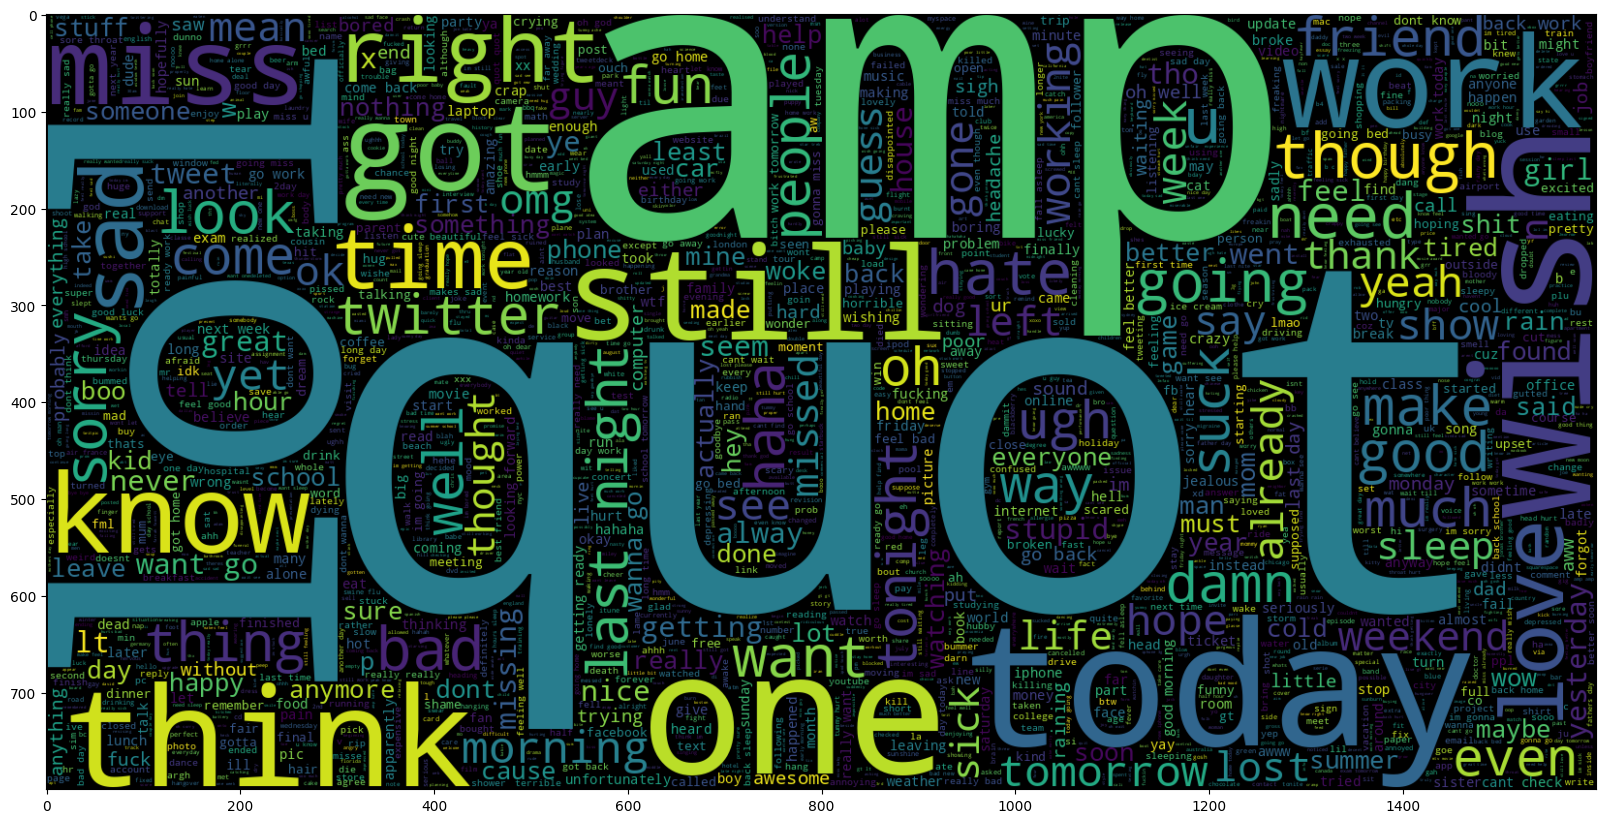

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Training and Testing </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    In this step, we will split our dataset into training and testing sets. This is crucial for evaluating the performance of our model.
</p>


In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [17]:
train_data.sample(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
540119,Negative,came back 8pm
994532,Positive,photoshop sessions minsky sharing techniques
555113,Negative,nope restart mail app started crashed syncing imap box
848456,Positive,sounds like might useful student type like
207180,Negative,critical mass chicago okay last night front pack fast made problems cars raced gaps also route old hat
994963,Positive,kime13 r certainly welcome
1079474,Positive,christine
903639,Positive,happy star wars day everyone
1028359,Positive,nightwolfwriter haz latte sitting right beside drink dears one drink
699817,Negative,miranda radtastic97 sleeping late nothing


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;"> Tokenization </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    Tokenization is the process of converting text into individual tokens, which can be words, subwords, or characters. This step is essential for preparing the text data for training a language model.
</p>


Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/tokenization.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`word_index` contains the index for each word

`vocab_size` represents the total number of word in the data corpus

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [19]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [20]:
labels = train_data.sentiment.unique().tolist()

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;"> Label Encoding </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    Label Encoding is the process of converting categorical labels into numerical format. This step is necessary for machine learning algorithms that require numerical input.
</p>


We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;"> Word Embedding </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    Word Embedding is a technique for converting words into numerical vectors that capture semantic meaning. This representation allows models to understand and process text data more effectively.
</p>


# Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

**Word Embedding** is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like **GloVe & Word2Vec** gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.


In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)

In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-07-26 09:45:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-26 09:45:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-26 09:45:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [23]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [24]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thanakomsn/glove6b300dtxt
!unzip glove6b300dtxt.zip

GLOVE_EMB = '/content/glove.6B.300d.txt' # Updated path assuming the file exists in '/content' after downloading

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt
License(s): DbCL-1.0
 99% 383M/386M [00:14<00:00, 38.4MB/s]
100% 386M/386M [00:14<00:00, 27.6MB/s]
Archive:  glove6b300dtxt.zip
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;"> Model Training - LSTM </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    In this section, we will train our model using Long Short-Term Memory (LSTM) networks. LSTMs are a type of recurrent neural network (RNN) capable of learning long-term dependencies, making them suitable for sequence prediction tasks.
</p>


We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors.

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 300)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [31]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
1250/1250 [==============================] - 211s 150ms/step - loss: 0.5195 - accuracy: 0.7394 - val_loss: 0.4812 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 167s 134ms/step - loss: 0.4876 - accuracy: 0.7623 - val_loss: 0.4733 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 168s 135ms/step - loss: 0.4775 - accuracy: 0.7691 - val_loss: 0.4687 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 166s 133ms/step - loss: 0.4711 - accuracy: 0.7732 - val_loss: 0.4635 - val_accuracy: 0.7781 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 162s 130ms/step - loss: 0.4667 - accuracy: 0.7757 - val_loss: 0.4614 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 166s 133ms/step - loss: 0.4630 - accuracy: 0.7783 - val_loss: 0.4622 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 7/50
1250/1250 [============

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">  Evaluating the Model</span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
   In this section, we will evaluate the performance of our trained model. Model evaluation involves examining various metrics to gauge how well the model is performing and to pinpoint areas for potential improvement.
</p>


Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

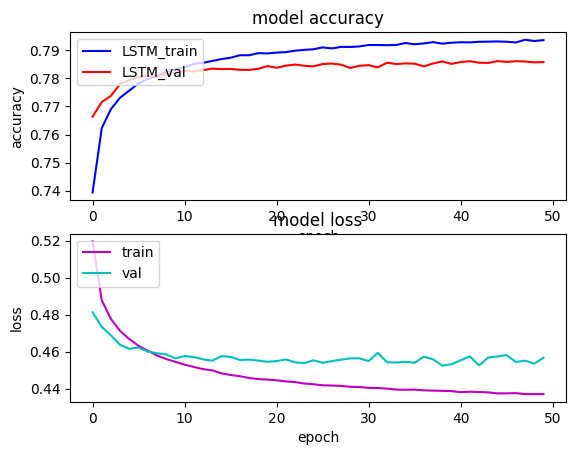

In [33]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [34]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 4s 65ms/step


<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Confusion Matrix </span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    The confusion matrix is a tool used to evaluate the performance of a classification model. It shows the counts of true positive, true negative, false positive, and false negative predictions, helping us understand the accuracy and errors of the model.
</p>


Confusion Matrix provide a nice overlook at the model's performance in classification task

In [35]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

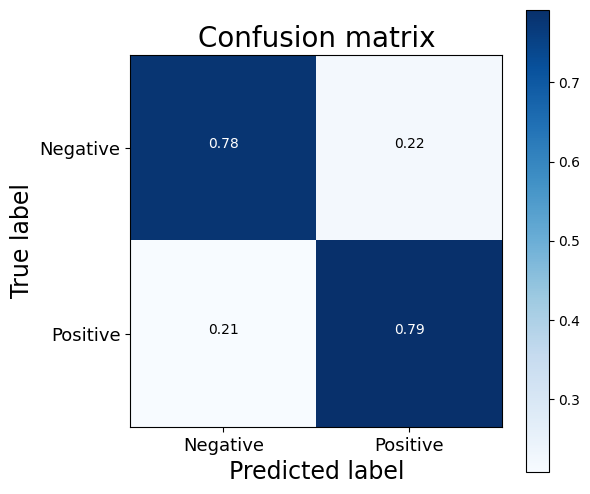

In [36]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

<div style="color:#333333; background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 15px; font-size: 2em; font-family: 'Arial', sans-serif; text-align:center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
    <span style="display: inline-block;">Classification Score</span>
</div>

<p style="font-family: 'Arial', sans-serif; font-size: 1.2em; color: #333333; margin-top: 20px;">
    The classification score reflects our model’s performance on the test data. It encompasses metrics such as accuracy, precision, recall, and F1 score, offering a thorough assessment of how effectively the model is making predictions.
</p>


In [37]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.79    160542
    Positive       0.78      0.79      0.79    159458

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



The model we've trained is quite impressive for NLP tasks, achieving around 80% accuracy, which is quite good given that baseline human accuracy is also relatively low for these tasks. You should explore the dataset further, as some tweets may be in languages other than English. This could affect the effectiveness of our embedding and tokenizing processes. However, in practical scenarios, this model should handle most sentiment analysis tasks effectively.